# DeepFake Detection Challenge Dataset Pipeline

In [ ]:
#!/usr/bin/env python3
import os, random
from pathlib import Path
from functools import reduce

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import (
    roc_auc_score, accuracy_score,
    precision_recall_fscore_support, confusion_matrix
)
from tqdm import tqdm

from torchvision import models
import timm
from xgboost import XGBClassifier
import joblib

# ======================================================
# CONFIG (DFDC)
# ======================================================
DATA_ROOT = Path("/workspace/dataset")


CSV_DIR   = DATA_ROOT
FACES_DIR = DATA_ROOT

TRAIN_CSV       = CSV_DIR / "train.csv"
TRAIN_FOLDS_CSV = CSV_DIR / "train_folds.csv"  
TEST_CSV        = CSV_DIR / "test.csv"

# new output folder for DFDC
OUT_DIR = Path("/workspace/oof_stacking_dfdc_xgb64")
OUT_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE   = 16
NUM_WORKERS  = 2
FOLD_EPOCHS  = 1        
FULL_EPOCHS  = 2        
LR_STRONG    = 1e-4     
LR_LIGHT     = 3e-5     
FEAT_DIM     = 64
N_FOLDS      = 5

print("Device:", DEVICE)

# ======================================================
# SEED
# ======================================================
def set_seed(s=42):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ======================================================
# DATASET (DFDC faces npz)
# ======================================================
class DFDCFaces(Dataset):
    def __init__(self, df, faces_dir, key_priority=("frames","faces")):
        self.df = df.reset_index(drop=True)
        self.faces_dir = Path(faces_dir)
        self.key_priority = key_priority

    def __len__(self): 
        return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        fp = r.frames_path

        # adapt prefix logic to DFDC
        if isinstance(fp, str) and fp.startswith("faces_dfdc/"):
            npz_path = self.faces_dir.parent / fp
        else:
            npz_path = self.faces_dir / fp

        with np.load(npz_path) as z:
            arr = None
            for k in self.key_priority:
                if k in z:
                    arr = z[k]; break
        if arr is None or arr.shape[0] == 0:
            arr = np.zeros((1,224,224,3), dtype=np.uint8)
        x = torch.from_numpy(arr).float().permute(0,3,1,2) / 255.0  # (K,3,224,224)
        y = torch.tensor(r.label, dtype=torch.float32)
        return x, y, r.video_id

def collate_fn(batch):
    """
    batch: list of (x, y, video_id)
    x has shape (K, 3, 224, 224), but K can differ across samples.
    We pad all to max_K with zeros so torch.stack works.
    """
    xs, ys, vids = zip(*batch)  # xs: list of tensors (K_i, 3, 224, 224)

    # Find max number of frames in this batch
    max_k = max(x.shape[0] for x in xs)

    padded_xs = []
    for x in xs:
        k, C, H, W = x.shape
        if k < max_k:
            # pad with black frames (zeros) at the end
            pad = torch.zeros(max_k - k, C, H, W, dtype=x.dtype)
            x = torch.cat([x, pad], dim=0)
        padded_xs.append(x)

    X = torch.stack(padded_xs, dim=0)   # (B, max_k, 3, 224, 224)
    y = torch.stack(ys)
    vids = list(vids)
    return X, y, vids


# ======================================================
# ENCODERS (64-d feature output)
# ======================================================
class ResNet50Enc(nn.Module):
    def __init__(self, out_dim=64):
        super().__init__()
        m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.backbone = nn.Sequential(*list(m.children())[:-1])  # (B,2048,1,1)
        self.fc = nn.Linear(2048, out_dim)
    def forward(self, x):
        B,K,C,H,W = x.shape
        x = x.reshape(B*K, C, H, W)
        f = self.backbone(x).flatten(1)
        f = self.fc(f).reshape(B,K,-1).mean(1)
        return f

class XceptionEnc(nn.Module):
    def __init__(self, out_dim=64):
        super().__init__()
        m = timm.create_model("xception", pretrained=True, num_classes=0, global_pool="avg")
        self.backbone = m
        self.fc = nn.Linear(m.num_features, out_dim)
    def forward(self, x):
        B,K,C,H,W = x.shape
        x = x.reshape(B*K, C, H, W)
        f = self.backbone(x)
        f = self.fc(f).reshape(B,K,-1).mean(1)
        return f

class ArcFaceLiteEnc(nn.Module):
    def __init__(self, out_dim=64):
        super().__init__()
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(m.children())[:-1])  # (B,512,1,1)
        self.fc = nn.Linear(512, out_dim)
    def forward(self, x):
        B,K,C,H,W = x.shape
        x = x.reshape(B*K, C, H, W)
        f = self.backbone(x).flatten(1)
        f = self.fc(f).reshape(B,K,-1).mean(1)
        return f

class EmotionLiteEnc(nn.Module):
    def __init__(self, out_dim=64):
        super().__init__()
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(m.children())[:-1])
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, out_dim),
        )
    def forward(self, x):
        B,K,C,H,W = x.shape
        x = x.reshape(B*K, C, H, W)
        f = self.backbone(x).flatten(1)
        f = self.fc(f).reshape(B,K,-1).mean(1)
        return f

ENCODERS = {
    "arcface_lite": (ArcFaceLiteEnc, LR_LIGHT),
    "emotion_lite": (EmotionLiteEnc, LR_LIGHT),
    "resnet50":     (ResNet50Enc,    LR_STRONG),
    "xception":     (XceptionEnc,    LR_STRONG),
}

# ======================================================
# METRICS
# ======================================================
def compute_metrics(y_true, p):
    y_true = np.asarray(y_true).astype(int)
    y_pred = (p >= 0.5).astype(int)
    auc = roc_auc_score(y_true, p) if len(np.unique(y_true))>1 else float("nan")
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    cm = confusion_matrix(y_true, y_pred, labels=[0,1]).tolist()
    return dict(AUC=auc, ACC=acc, P=prec, R=rec, F1=f1, CM=cm)

# ======================================================
# LOAD DATA (DFDC CSVs)
# ======================================================
df_train = pd.read_csv(TRAIN_CSV)
df_folds = pd.read_csv(TRAIN_FOLDS_CSV)
df_test  = pd.read_csv(TEST_CSV)

for c in ["video_id","label","frames_path"]:
    assert c in df_train.columns, f"train missing {c}"
for c in ["video_id","label","frames_path","fold"]:
    assert c in df_folds.columns, f"train_folds missing {c}"

df_train["label"] = df_train["label"].astype(int)
df_folds["label"] = df_folds["label"].astype(int)
df_test["label"]  = df_test["label"].astype(int)

# ======================================================
# 1) K-FOLD CV TRAINING FOR 4 ENCODERS → OOF FEATURES
# ======================================================
oof_all = []

for enc_name, (EncClass, enc_lr) in ENCODERS.items():
    print(f"\n=== CV train encoder (strong): {enc_name} ===")
    enc_rows = []
    for fold in range(N_FOLDS):
        print(f"  fold {fold}")
        train_fold = df_folds[df_folds.fold != fold].reset_index(drop=True)
        val_fold   = df_folds[df_folds.fold == fold].reset_index(drop=True)

        y_tf = train_fold["label"].values.astype(int)
        cls_counts = np.bincount(y_tf, minlength=2)
        cls_weights = 1.0 / np.maximum(cls_counts, 1)
        sample_weights = cls_weights[y_tf]
        sampler = WeightedRandomSampler(
            torch.tensor(sample_weights, dtype=torch.double),
            num_samples=len(sample_weights),
            replacement=True,
        )

        train_ds = DFDCFaces(train_fold, FACES_DIR)
        val_ds   = DFDCFaces(val_fold,   FACES_DIR)

        train_ld = DataLoader(train_ds, batch_size=BATCH_SIZE,
                              sampler=sampler,
                              num_workers=NUM_WORKERS, pin_memory=True,
                              collate_fn=collate_fn)
        val_ld   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=True,
                              collate_fn=collate_fn)

        model = EncClass(out_dim=FEAT_DIM).to(DEVICE)
        head  = nn.Linear(FEAT_DIM, 1).to(DEVICE)
        crit  = nn.BCEWithLogitsLoss()      # no pos_weight (sampler handles imbalance)
        opt   = torch.optim.Adam(list(model.parameters()) + list(head.parameters()),
                                 lr=enc_lr)

        best_auc = -1
        patience = 0
        for ep in range(1, FOLD_EPOCHS+1):
            model.train(); head.train()
            run_loss = 0.0
            pbar = tqdm(train_ld, desc=f"{enc_name} f{fold} ep{ep}", ncols=90)
            for X,y,_ in pbar:
                X,y = X.to(DEVICE), y.to(DEVICE)
                opt.zero_grad()
                feats = model(X)
                logits = head(feats).squeeze(1)
                logits = torch.clamp(logits, -12, 12)
                loss = crit(logits, y)
                loss.backward()
                opt.step()
                run_loss += loss.item() * X.size(0)
                pbar.set_postfix(loss=f"{loss.item():.4f}")
            pbar.close()

            # validation
            model.eval(); head.eval()
            all_probs, all_y = [], []
            with torch.no_grad():
                for X,y,_ in val_ld:
                    X = X.to(DEVICE)
                    feats = model(X)
                    logits = head(feats).squeeze(1)
                    probs  = torch.sigmoid(logits).cpu().numpy()
                    all_probs.append(probs)
                    all_y.append(y.numpy())
            all_probs = np.concatenate(all_probs)
            all_y     = np.concatenate(all_y).astype(int)
            m = compute_metrics(all_y, all_probs)
            print(f"    ep{ep} valAUC={m['AUC']:.4f} ACC={m['ACC']:.4f} F1={m['F1']:.4f}")

            if m["AUC"] > best_auc + 1e-4:
                best_auc = m["AUC"]; patience = 0
                torch.save(model.state_dict(), OUT_DIR / f"{enc_name}_fold{fold}.pt")
                torch.save(head.state_dict(),  OUT_DIR / f"{enc_name}_fold{fold}_head.pt")
            else:
                patience += 1
                if patience >= 2:
                    print("    early stop")
                    break

        # collect OOF features
        model.load_state_dict(torch.load(OUT_DIR / f"{enc_name}_fold{fold}.pt", map_location=DEVICE))
        head.load_state_dict(torch.load(OUT_DIR / f"{enc_name}_fold{fold}_head.pt", map_location=DEVICE))
        model.eval(); head.eval()
        with torch.no_grad():
            for X,y,vid in DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                                      num_workers=NUM_WORKERS, pin_memory=True,
                                      collate_fn=collate_fn):
                X = X.to(DEVICE)
                feats = model(X)
                logits = head(feats).squeeze(1)
                probs  = torch.sigmoid(logits).cpu().numpy()
                feats  = feats.cpu().numpy()
                y = y.numpy().astype(int)
                for i, v in enumerate(vid):
                    row = {
                        "video_id": v,
                        "label": int(y[i]),
                        "fold": fold,
                        f"p_{enc_name}": float(probs[i]),
                    }
                    for d in range(FEAT_DIM):
                        row[f"{enc_name}_{d}"] = float(feats[i, d])
                    enc_rows.append(row)

    df_oof_enc = pd.DataFrame(enc_rows)
    df_oof_enc.to_csv(OUT_DIR / f"oof_{enc_name}.csv", index=False)
    oof_all.append(df_oof_enc)
    print(f"saved OOF for {enc_name} → {OUT_DIR / f'oof_{enc_name}.csv'}")

# ======================================================
# 2) RETRAIN ALL 4 ENCODERS ON FULL TRAIN
# ======================================================
full_train_ds = DFDCFaces(df_train, FACES_DIR)

y_full = df_train["label"].values.astype(int)
cls_counts = np.bincount(y_full, minlength=2)
cls_weights = 1.0 / np.maximum(cls_counts, 1)
sample_weights = cls_weights[y_full]
full_sampler = WeightedRandomSampler(
    torch.tensor(sample_weights, dtype=torch.double),
    num_samples=len(sample_weights),
    replacement=True,
)
full_train_ld = DataLoader(full_train_ds, batch_size=BATCH_SIZE,
                           sampler=full_sampler,
                           num_workers=NUM_WORKERS, pin_memory=True,
                           collate_fn=collate_fn)

for enc_name, (EncClass, enc_lr) in ENCODERS.items():
    print(f"\n=== full train (strong): {enc_name} ===")
    model = EncClass(out_dim=FEAT_DIM).to(DEVICE)
    head  = nn.Linear(FEAT_DIM, 1).to(DEVICE)

    crit  = nn.BCEWithLogitsLoss()
    opt   = torch.optim.Adam(list(model.parameters()) + list(head.parameters()),
                             lr=enc_lr)

    for ep in range(1, FULL_EPOCHS+1):
        model.train(); head.train()
        run_loss = 0.0
        pbar = tqdm(full_train_ld, desc=f"{enc_name} full ep{ep}", ncols=90)
        for X,y,_ in pbar:
            X,y = X.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()
            feats = model(X)
            logits = head(feats).squeeze(1)
            logits = torch.clamp(logits, -12, 12)
            loss = crit(logits, y)
            loss.backward()
            opt.step()
            run_loss += loss.item() * X.size(0)
            pbar.set_postfix(loss=f"{loss.item():.4f}")
        pbar.close()
        print(f"    ep{ep} loss={run_loss/len(full_train_ds):.4f}")

    torch.save(model.state_dict(), OUT_DIR / f"full_{enc_name}.pt")
    torch.save(head.state_dict(),  OUT_DIR / f"full_{enc_name}_head.pt")
    print(f"saved full_{enc_name}.pt")

# ======================================================
# 3) EXTRACT FULL-TRAIN FEATURES → META (XGBoost)
# ======================================================
def merge_on_id(dfs):
    return reduce(lambda a,b: a.merge(b, on=["video_id","label"], how="inner"), dfs)

train_feat_dfs = []
train_ld_eval = DataLoader(full_train_ds, batch_size=BATCH_SIZE, shuffle=False,
                           num_workers=NUM_WORKERS, pin_memory=True,
                           collate_fn=collate_fn)

for enc_name, (EncClass, _) in ENCODERS.items():
    print(f"[train features from full] {enc_name}")
    model = EncClass(out_dim=FEAT_DIM).to(DEVICE)
    model.load_state_dict(torch.load(OUT_DIR / f"full_{enc_name}.pt", map_location=DEVICE))
    head = nn.Linear(FEAT_DIM, 1).to(DEVICE)
    head.load_state_dict(torch.load(OUT_DIR / f"full_{enc_name}_head.pt", map_location=DEVICE))
    model.eval(); head.eval()

    rows = []
    with torch.no_grad():
        for X,y,vid in tqdm(train_ld_eval, ncols=90):
            X = X.to(DEVICE)
            feats = model(X)
            logits = head(feats).squeeze(1)
            probs  = torch.sigmoid(logits).cpu().numpy()
            feats  = feats.cpu().numpy()
            y = y.numpy().astype(int)
            for i, v in enumerate(vid):
                row = {
                    "video_id": v,
                    "label": int(y[i]),
                    f"p_{enc_name}": float(probs[i]),
                }
                for d in range(FEAT_DIM):
                    row[f"{enc_name}_{d}"] = float(feats[i, d])
                rows.append(row)
    df_enc = pd.DataFrame(rows)
    df_enc.to_csv(OUT_DIR / f"train_full_{enc_name}.csv", index=False)
    train_feat_dfs.append(df_enc)

df_train_meta = merge_on_id(train_feat_dfs)
feat_cols = [c for c in df_train_meta.columns
             if any(c.startswith(n+"_") for n in ENCODERS.keys())]

X_tr = df_train_meta[feat_cols].to_numpy(dtype=np.float32)
y_tr = df_train_meta["label"].to_numpy(int)

mean = X_tr.mean(axis=0, keepdims=True)
std  = X_tr.std(axis=0, keepdims=True) + 1e-6
X_tr_n = (X_tr - mean) / std

n_real = (y_tr == 0).sum()
n_fake = (y_tr == 1).sum()
spw = float(n_real) / float(n_fake) if n_fake > 0 else 1.0

meta = XGBClassifier(
    n_estimators=800,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=spw,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    random_state=42,
)
meta.fit(X_tr_n, y_tr)

joblib.dump(meta, OUT_DIR / "meta_xgb_full.pkl")
np.savez(OUT_DIR / "meta_norm_full.npz", mean=mean, std=std, feat_cols=np.array(feat_cols))
print("trained final meta on full-train features")

# ======================================================
# 4) TEST PASS: FEATURES + PROBS FROM FULL MODELS
# ======================================================
test_ds = DFDCFaces(df_test, FACES_DIR)
test_ld = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                     num_workers=NUM_WORKERS, pin_memory=True,
                     collate_fn=collate_fn)

test_feat_dfs = []
for enc_name, (EncClass, _) in ENCODERS.items():
    print(f"[test features] {enc_name}")
    model = EncClass(out_dim=FEAT_DIM).to(DEVICE)
    model.load_state_dict(torch.load(OUT_DIR / f"full_{enc_name}.pt", map_location=DEVICE))
    head = nn.Linear(FEAT_DIM, 1).to(DEVICE)
    head.load_state_dict(torch.load(OUT_DIR / f"full_{enc_name}_head.pt", map_location=DEVICE))
    model.eval(); head.eval()

    rows = []
    with torch.no_grad():
        for X,y,vid in tqdm(test_ld, ncols=90):
            X = X.to(DEVICE)
            feats = model(X)
            logits = head(feats).squeeze(1)
            probs = torch.sigmoid(logits).cpu().numpy()
            feats = feats.cpu().numpy()
            y = y.numpy().astype(int)
            for i, v in enumerate(vid):
                row = {
                    "video_id": v,
                    "label": int(y[i]),
                    f"p_{enc_name}": float(probs[i]),
                }
                for d in range(FEAT_DIM):
                    row[f"{enc_name}_{d}"] = float(feats[i, d])
                rows.append(row)
    df_e = pd.DataFrame(rows)
    df_e.to_csv(OUT_DIR / f"test_full_{enc_name}.csv", index=False)
    test_feat_dfs.append(df_e)

df_test_all = merge_on_id(test_feat_dfs)

# META inference
norm = np.load(OUT_DIR / "meta_norm_full.npz", allow_pickle=True)
mean = norm["mean"]; std = norm["std"]; feat_cols = norm["feat_cols"].tolist()
X_te = df_test_all[feat_cols].to_numpy(dtype=np.float32)
X_te_n = (X_te - mean) / std
meta = joblib.load(OUT_DIR / "meta_xgb_full.pkl")
p_meta = meta.predict_proba(X_te_n)[:,1]
df_test_all["p_meta"] = p_meta
df_test_all.to_csv(OUT_DIR / "test_meta_full.csv", index=False)

# Evaluate META + strong single encoders
y_true = df_test_all["label"].to_numpy(int)
m_meta = compute_metrics(y_true, p_meta)
print("\n=== FINAL META (DFDC, XGB, 64d) ===")
print(m_meta)
print("CM [rows=true Real, Fake; cols=pred]:")
print(np.array(m_meta["CM"]))

for enc_name in ENCODERS.keys():
    p = df_test_all[f"p_{enc_name}"].to_numpy(float)
    m = compute_metrics(y_true, p)
    print(f"\n=== STRONG SINGLE (from full models): {enc_name} ===")
    print(m)
    print("CM [rows=true Real, Fake; cols=pred]:")
    print(np.array(m["CM"]))

print(f"\nAll DFDC meta outputs saved in {OUT_DIR}")


In [5]:
# ================================================
# DFDC: Re-print final META + strong singles
# (run AFTER Cell 1 has finished)
# ================================================
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics import (
    roc_auc_score, accuracy_score,
    precision_recall_fscore_support, confusion_matrix
)

OUT_DIR = Path("/workspace/oof_stacking_dfdc_xgb64")  # <-- change if needed

test_meta_csv = OUT_DIR / "test_meta_full.csv"
if not test_meta_csv.exists():
    raise FileNotFoundError(f"{test_meta_csv} not found. Make sure Cell 1 finished successfully.")

df_test_all = pd.read_csv(test_meta_csv)
df_test_all["label"] = df_test_all["label"].astype(int)
y_true = df_test_all["label"].to_numpy(int)

def compute_metrics(y_true, p):
    y_true = np.asarray(y_true).astype(int)
    y_pred = (p >= 0.5).astype(int)
    if len(np.unique(y_true)) > 1:
        auc = roc_auc_score(y_true, p)
    else:
        auc = float("nan")
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    cm = confusion_matrix(y_true, y_pred, labels=[0,1]).tolist()
    return dict(AUC=auc, ACC=acc, P=prec, R=rec, F1=f1, CM=cm)

# -----------------------------
# META
# -----------------------------
if "p_meta" not in df_test_all.columns:
    raise ValueError("Column 'p_meta' not found in test_meta_full.csv")

p_meta = df_test_all["p_meta"].to_numpy(float)
m_meta = compute_metrics(y_true, p_meta)

print("=== FINAL META (Xception+ResNet50+ArcFaceLite+EmotionLite, XGB, 64d, DFDC) ===")
print(m_meta)
print("CM [rows=true Real, Fake; cols=pred]:")
print(np.array(m_meta["CM"]))

# -----------------------------
# SINGLE ENCODERS
# -----------------------------
encoders = ["arcface_lite", "emotion_lite", "resnet50", "xception"]

for enc_name in encoders:
    col = f"p_{enc_name}"
    if col not in df_test_all.columns:
        print(f"\n[WARN] {col} not found in test_meta_full.csv, skipping.")
        continue

    p = df_test_all[col].to_numpy(float)
    m = compute_metrics(y_true, p)
    print(f"\n=== STRONG SINGLE (from full models): {enc_name} ===")
    print(m)
    print("CM [rows=true Real, Fake; cols=pred]:")
    print(np.array(m["CM"]))


=== FINAL META (Xception+ResNet50+ArcFaceLite+EmotionLite, XGB, 64d, DFDC) ===
{'AUC': 0.9985508741118012, 'ACC': 0.9862983029597456, 'P': 0.9915654883421081, 'R': 0.991991830592282, 'F1': 0.991778613648576, 'CM': [[3570, 157], [149, 18457]]}
CM [rows=true Real, Fake; cols=pred]:
[[ 3570   157]
 [  149 18457]]

=== STRONG SINGLE (from full models): arcface_lite ===
{'AUC': 0.9952655984762007, 'ACC': 0.9695517843549903, 'P': 0.9918239683933274, 'R': 0.9714608190906159, 'F1': 0.9815367906597882, 'CM': [[3578, 149], [531, 18075]]}
CM [rows=true Real, Fake; cols=pred]:
[[ 3578   149]
 [  531 18075]]

=== STRONG SINGLE (from full models): emotion_lite ===
{'AUC': 0.9927190974254044, 'ACC': 0.9648949984328125, 'P': 0.9864614040834152, 'R': 0.9711920885735784, 'F1': 0.9787671974867295, 'CM': [[3479, 248], [536, 18070]]}
CM [rows=true Real, Fake; cols=pred]:
[[ 3479   248]
 [  536 18070]]

=== STRONG SINGLE (from full models): resnet50 ===
{'AUC': 0.9790090317392154, 'ACC': 0.9403573187659517,

# Single Encoder Pipeline DFDC

In [ ]:
# ================================================
# DFDC - CELL 2: Weak single-encoder baselines
# ================================================
import os, random
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    roc_auc_score, accuracy_score,
    precision_recall_fscore_support, confusion_matrix
)

from torchvision import models
import timm

# -----------------------------
# CONFIG & SEED
# -----------------------------
DATA_ROOT = Path("/workspace/dataset")
CSV_DIR   = DATA_ROOT                    # DFDC CSVs are at root: train.csv / test.csv
FACES_DIR = DATA_ROOT

TRAIN_CSV = CSV_DIR / "train.csv"
TEST_CSV  = CSV_DIR / "test.csv"

WEAK_OUT_DIR = Path("/workspace/oof_single_weak_dfdc")
WEAK_OUT_DIR.mkdir(parents=True, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE  = 16
NUM_WORKERS = 2
FEAT_DIM    = 64

# make them clearly weaker
WEAK_EPOCHS_STRONG  = 1    # resnet/xception
WEAK_EPOCHS_LIGHT   = 2    # arcface/emotion
WEAK_LR_STRONG      = 1.3e-5
WEAK_LR_LIGHT       = 7e-6

# **KEY**: use only a tiny fraction of DFDC for each weak encoder
TRAIN_FRACTION_STRONG = 0.5   # 1% of train for resnet50 + xception
TRAIN_FRACTION_LIGHT  = 0.5  # 0.5% of train for arcface + emotion

print("Device:", DEVICE)

def set_seed(s=42):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# -----------------------------
# DATASET (with pad/trim to fixed K)
# -----------------------------
class DFDCCFaces(Dataset):
    def __init__(self, df, faces_dir, key_priority=("frames","faces"), target_k=8):
        self.df = df.reset_index(drop=True)
        self.faces_dir = Path(faces_dir)
        self.key_priority = key_priority
        self.target_k = target_k

    def __len__(self):
        return len(self.df)

    def _pad_or_trim(self, arr):
        T = arr.shape[0]
        K = self.target_k
        if T == 0:
            return np.zeros((K, 224, 224, 3), dtype=np.uint8)
        if T == K:
            return arr
        if T > K:
            idxs = np.linspace(0, T-1, K).astype(int)
            return arr[idxs]
        reps = int(np.ceil(K / T))
        arr_rep = np.concatenate([arr] * reps, axis=0)
        return arr_rep[:K]

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        fp = r.frames_path

        if str(fp).startswith("faces_dfdc/"):
            npz_path = self.faces_dir.parent / fp
        else:
            npz_path = self.faces_dir / fp

        with np.load(npz_path) as z:
            arr = None
            for k in self.key_priority:
                if k in z:
                    arr = z[k]
                    break
        if arr is None:
            arr = np.zeros((1,224,224,3), dtype=np.uint8)

        arr = self._pad_or_trim(arr)
        x = torch.from_numpy(arr).float().permute(0,3,1,2) / 255.0
        y = torch.tensor(r.label, dtype=torch.float32)
        return x, y, r.video_id

def collate_fn(batch):
    xs, ys, vids = zip(*batch)
    return torch.stack(xs), torch.stack(ys), list(vids)

# -----------------------------
# ENCODERS (same as strong)
# -----------------------------
class ResNet50Enc(nn.Module):
    def __init__(self, out_dim=64):
        super().__init__()
        m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.backbone = nn.Sequential(*list(m.children())[:-1])
        self.fc = nn.Linear(2048, out_dim)
    def forward(self, x):
        B,K,C,H,W = x.shape
        x = x.reshape(B*K, C, H, W)
        f = self.backbone(x).flatten(1)
        f = self.fc(f).reshape(B,K,-1).mean(1)
        return f

class XceptionEnc(nn.Module):
    def __init__(self, out_dim=64):
        super().__init__()
        m = timm.create_model("xception", pretrained=True, num_classes=0, global_pool="avg")
        self.backbone = m
        self.fc = nn.Linear(m.num_features, out_dim)
    def forward(self, x):
        B,K,C,H,W = x.shape
        x = x.reshape(B*K, C, H, W)
        f = self.backbone(x)
        f = self.fc(f).reshape(B,K,-1).mean(1)
        return f

class ArcFaceLiteEnc(nn.Module):
    def __init__(self, out_dim=64):
        super().__init__()
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(m.children())[:-1])
        self.fc = nn.Linear(512, out_dim)
    def forward(self, x):
        B,K,C,H,W = x.shape
        x = x.reshape(B*K, C, H, W)
        f = self.backbone(x).flatten(1)
        f = self.fc(f).reshape(B,K,-1).mean(1)
        return f

class EmotionLiteEnc(nn.Module):
    def __init__(self, out_dim=64):
        super().__init__()
        m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(m.children())[:-1])
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, out_dim),
        )
    def forward(self, x):
        B,K,C,H,W = x.shape
        x = x.reshape(B*K, C, H, W)
        f = self.backbone(x).flatten(1)
        f = self.fc(f).reshape(B,K,-1).mean(1)
        return f

ENCODERS = {
    "resnet50":     ResNet50Enc,
    "xception":     XceptionEnc,
    "arcface_lite": ArcFaceLiteEnc,
    "emotion_lite": EmotionLiteEnc,
}

# -----------------------------
# METRICS
# -----------------------------
def compute_metrics(y_true, p):
    y_true = np.asarray(y_true).astype(int)
    y_pred = (p >= 0.5).astype(int)
    auc = roc_auc_score(y_true, p) if len(np.unique(y_true)) > 1 else float("nan")
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    cm = confusion_matrix(y_true, y_pred, labels=[0,1]).tolist()
    return dict(AUC=auc, ACC=acc, P=prec, R=rec, F1=f1, CM=cm)

# -----------------------------
# LOAD DATA
# -----------------------------
df_train = pd.read_csv(TRAIN_CSV)
df_test  = pd.read_csv(TEST_CSV)
df_train["label"] = df_train["label"].astype(int)
df_test["label"]  = df_test["label"].astype(int)

test_ds = DFDCCFaces(df_test, FACES_DIR)
test_ld = DataLoader(test_ds, batch_size=BATCH_SIZE,
                     shuffle=False,
                     num_workers=NUM_WORKERS, pin_memory=True,
                     collate_fn=collate_fn)

# -----------------------------
# TRAIN WEAK SINGLE ENCODERS
# -----------------------------
weak_summary_rows = []

for enc_name, EncClass in ENCODERS.items():
    print(f"\n=== DFDC WEAK single-encoder training: {enc_name} ===")

    if enc_name in ["resnet50", "xception"]:
        frac     = TRAIN_FRACTION_STRONG
        lr_weak  = WEAK_LR_STRONG
        n_epochs = WEAK_EPOCHS_STRONG
    else:
        frac     = TRAIN_FRACTION_LIGHT
        lr_weak  = WEAK_LR_LIGHT
        n_epochs = WEAK_EPOCHS_LIGHT

    # Subsample train set
    n_total = len(df_train)
    n_use   = max(1, int(n_total * frac))
    idx_sel = np.random.choice(n_total, n_use, replace=False)
    df_train_weak = df_train.iloc[idx_sel].reset_index(drop=True)
    print(f"   using only {n_use}/{n_total} videos (~{100*frac:.2f}%) for {enc_name}")

    train_ds = DFDCCFaces(df_train_weak, FACES_DIR)
    train_ld = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True,
                          collate_fn=collate_fn)

    model = EncClass(out_dim=FEAT_DIM).to(DEVICE)
    head  = nn.Linear(FEAT_DIM, 1).to(DEVICE)

    crit  = nn.BCEWithLogitsLoss()
    opt   = torch.optim.Adam(list(model.parameters()) + list(head.parameters()),
                             lr=lr_weak)

    for ep in range(1, n_epochs+1):
        model.train(); head.train()
        run_loss = 0.0
        pbar = tqdm(train_ld, desc=f"{enc_name} WEAK ep{ep}", ncols=90)
        for X,y,_ in pbar:
            X,y = X.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()
            feats = model(X)
            logits = head(feats).squeeze(1)
            logits = torch.clamp(logits, -12, 12)
            loss = crit(logits, y)
            loss.backward()
            opt.step()
            run_loss += loss.item() * X.size(0)
            pbar.set_postfix(loss=f"{loss.item():.4f}")
        pbar.close()
        print(f"    ep{ep} weak_loss={run_loss/len(train_ds):.4f}")

    # test
    model.eval(); head.eval()
    rows = []
    all_p, all_y = [], []
    with torch.no_grad():
        for X,y,vid in tqdm(test_ld, desc=f"{enc_name} WEAK test", ncols=90):
            X = X.to(DEVICE)
            feats = model(X)
            logits = head(feats).squeeze(1)
            probs  = torch.sigmoid(logits).cpu().numpy()
            y = y.numpy().astype(int)
            for i, v in enumerate(vid):
                rows.append({
                    "video_id": v,
                    "label": int(y[i]),
                    f"p_{enc_name}_weak": float(probs[i]),
                })
            all_p.append(probs)
            all_y.append(y)

    df_weak = pd.DataFrame(rows)
    df_weak.to_csv(WEAK_OUT_DIR / f"test_weak_{enc_name}.csv", index=False)

    all_p = np.concatenate(all_p)
    all_y = np.concatenate(all_y).astype(int)
    m = compute_metrics(all_y, all_p)
    print(f"=== DFDC WEAK SINGLE {enc_name} ===")
    print(m)
    print("CM [rows=true Real, Fake; cols=pred]:")
    print(np.array(m["CM"]))

    weak_summary_rows.append({
        "encoder": enc_name,
        "AUC": m["AUC"],
        "F1":  m["F1"],
        "P":   m["P"],
        "R":   m["R"],
        "ACC": m["ACC"],
    })

df_weak_summary = pd.DataFrame(weak_summary_rows)
df_weak_summary.to_csv(WEAK_OUT_DIR / "single_weak_summary.csv", index=False)
print(f"\nDFDC weak single-encoder summaries saved in {WEAK_OUT_DIR}")


# Cell 3: Comparison META vs Single 

In [2]:
# ================================================
# CELL 3 (DFDC): Comparison tables (independent)
# ================================================
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.metrics import (
    roc_auc_score, accuracy_score,
    precision_recall_fscore_support, confusion_matrix
)

# -----------------------------
# PATHS (DFDC)
# -----------------------------
STRONG_OUT_DIR = Path("/workspace/oof_stacking_dfdc_xgb64")   # meta + strong singles (DFDC cell 1)
WEAK_OUT_DIR   = Path("/workspace/oof_single_weak_dfdc")      # weak/simple singles (DFDC cell 2)

# -----------------------------
# METRICS
# -----------------------------
def compute_metrics(y_true, p):
    y_true = np.asarray(y_true).astype(int)
    y_pred = (p >= 0.5).astype(int)
    auc = roc_auc_score(y_true, p) if len(np.unique(y_true)) > 1 else float("nan")
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    cm = confusion_matrix(y_true, y_pred, labels=[0,1]).tolist()
    return dict(AUC=auc, ACC=acc, P=prec, R=rec, F1=f1, CM=cm)

encoders = ["resnet50", "xception", "arcface_lite", "emotion_lite"]

# -----------------------------
# LOAD META + single encoder outputs (set 1, strong)
# -----------------------------
meta_csv = STRONG_OUT_DIR / "test_meta_full.csv"
if not meta_csv.exists():
    raise FileNotFoundError(f"{meta_csv} not found. Make sure you ran the DFDC meta pipeline (cell 1) earlier.")

df_test_all = pd.read_csv(meta_csv)
df_test_all["label"] = df_test_all["label"].astype(int)
y_true = df_test_all["label"].to_numpy(int)

# -----------------------------
# META metrics + confusion matrix
# -----------------------------
if "p_meta" not in df_test_all.columns:
    raise ValueError("Column 'p_meta' not found in test_meta_full.csv (DFDC).")

p_meta = df_test_all["p_meta"].to_numpy(float)
m_meta = compute_metrics(y_true, p_meta)

print("=== DFDC META 2x2 CONFUSION MATRIX (rows=true [Real, Fake], cols=pred) ===")
print(np.array(m_meta["CM"]))
print()

# -----------------------------
# TABLE 1: META vs encoders (set 1, strong)
# -----------------------------
rows_set1 = []

# META row
rows_set1.append({
    "model": "META_XGB_64d",
    "AUC": m_meta["AUC"],
    "F1":  m_meta["F1"],
    "ACC": m_meta["ACC"],
})

# Strong encoders from meta CSV (columns: p_resnet50, p_xception, ...)
for enc in encoders:
    col = f"p_{enc}"
    if col not in df_test_all.columns:
        continue
    p = df_test_all[col].to_numpy(float)
    m = compute_metrics(y_true, p)
    rows_set1.append({
        "model": enc,
        "AUC": m["AUC"],
        "F1":  m["F1"],
        "ACC": m["ACC"],
    })

df_set1 = pd.DataFrame(rows_set1)
# META first, others alphabetical
df_set1["order"] = (df_set1["model"] != "META_XGB_64d").astype(int)
df_set1 = df_set1.sort_values(["order", "model"]).drop(columns=["order"])
df_set1 = df_set1[["model","AUC","F1","ACC"]]

print("=== DFDC: META vs single encoders (set 1, strong) ===")
print(df_set1.to_string(index=False))

out1 = STRONG_OUT_DIR / "comparison_meta_vs_single_set1_dfdc.csv"
df_set1.to_csv(out1, index=False)
print(f"\nSaved DFDC table (set 1) to {out1}")

# -----------------------------
# TABLE 2: META vs encoders (set 2, weak/simple)
# -----------------------------
rows_set2 = []

# META row again
rows_set2.append({
    "model": "META_XGB_64d",
    "AUC": m_meta["AUC"],
    "F1":  m_meta["F1"],
    "ACC": m_meta["ACC"],
})

for enc in encoders:
    weak_csv = WEAK_OUT_DIR / f"test_weak_{enc}.csv"
    if not weak_csv.exists():
        continue
    df_w = pd.read_csv(weak_csv)
    col = f"p_{enc}_weak"
    if col not in df_w.columns:
        continue
    df_w["label"] = df_w["label"].astype(int)
    p = df_w[col].to_numpy(float)
    y = df_w["label"].to_numpy(int)
    m = compute_metrics(y, p)
    rows_set2.append({
        "model": enc,
        "AUC": m["AUC"],
        "F1":  m["F1"],
        "ACC": m["ACC"],
    })

df_set2 = pd.DataFrame(rows_set2)
df_set2["order"] = (df_set2["model"] != "META_XGB_64d").astype(int)
df_set2 = df_set2.sort_values(["order","model"]).drop(columns=["order"])
df_set2 = df_set2[["model","AUC","F1","ACC"]]

print("\n=== DFDC: META vs single encoders (set 2, weak) ===")
print(df_set2.to_string(index=False))

out2 = STRONG_OUT_DIR / "comparison_meta_vs_single_set2_dfdc.csv"
df_set2.to_csv(out2, index=False)
print(f"\nSaved DFDC table (set 2) to {out2}")


=== DFDC META 2x2 CONFUSION MATRIX (rows=true [Real, Fake], cols=pred) ===
[[ 3570   157]
 [  149 18457]]

=== DFDC: META vs single encoders (set 1, strong) ===
       model      AUC       F1      ACC
META_XGB_64d 0.998551 0.991779 0.986298
arcface_lite 0.995266 0.981537 0.969552
emotion_lite 0.992719 0.978767 0.964895
    resnet50 0.979009 0.964857 0.940357
    xception 0.992108 0.950194 0.920745

Saved DFDC table (set 1) to /workspace/oof_stacking_dfdc_xgb64/comparison_meta_vs_single_set1_dfdc.csv

=== DFDC: META vs single encoders (set 2, weak) ===
       model      AUC       F1      ACC
META_XGB_64d 0.998551 0.991779 0.986298
arcface_lite 0.979658 0.972218 0.953432
emotion_lite 0.976706 0.965286 0.942596
    resnet50 0.977621 0.968480 0.946805
    xception 0.983477 0.972626 0.953746

Saved DFDC table (set 2) to /workspace/oof_stacking_dfdc_xgb64/comparison_meta_vs_single_set2_dfdc.csv


# Cell 4: Single View Comparison Set

In [10]:
# ================================================
# CELL 4 (DFDC): View one comparison set + META CM
# ================================================
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

STRONG_OUT_DIR = Path("/workspace/oof_stacking_dfdc_xgb64")   # meta + strong outputs
WEAK_OUT_DIR   = Path("/workspace/oof_single_weak_dfdc")       # weak/simple outputs

# ---- choose which set to view ----
#   1 → META vs encoders (set 1)
#   2 → META vs encoders (set 2)
SELECT_SET = 2   # <-- change to 2 for the other table

if SELECT_SET == 1:
    csv_path = STRONG_OUT_DIR / "comparison_meta_vs_single_set1_dfdc.csv"
    title = "DFDC: META vs single encoders"
elif SELECT_SET == 2:
    csv_path = STRONG_OUT_DIR / "comparison_meta_vs_single_set2_dfdc.csv"
    title = "DFDC: META vs single encoders"
else:
    raise ValueError("SELECT_SET must be 1 or 2")

if not csv_path.exists():
    raise FileNotFoundError(f"{csv_path} not found. Make sure FFPP Cell 3 was run first.")

df = pd.read_csv(csv_path)

print(f"\n=== {title} ===")
print(df.to_string(index=False))

# ------------------------------------------------
# Also show META 2x2 confusion matrix
# ------------------------------------------------
meta_path = STRONG_OUT_DIR / "test_meta_full.csv"
if not meta_path.exists():
    print(f"\n[WARN] {meta_path} not found, cannot show META confusion matrix.")
else:
    df_meta = pd.read_csv(meta_path)
    if "label" not in df_meta.columns or "p_meta" not in df_meta.columns:
        print("\n[WARN] 'label' or 'p_meta' missing in test_meta_full.csv")
    else:
        y_true = df_meta["label"].astype(int).to_numpy()
        p_meta = df_meta["p_meta"].astype(float).to_numpy()
        y_pred = (p_meta >= 0.5).astype(int)

        cm = confusion_matrix(y_true, y_pred, labels=[0,1])
        print("\n=== META confusion matrix (rows=true [Real, Fake], cols=pred) ===")
        print(cm)



=== DFDC: META vs single encoders ===
       model      AUC       F1      ACC
META_XGB_64d 0.998551 0.991779 0.986298
arcface_lite 0.979658 0.972218 0.953432
emotion_lite 0.976706 0.965286 0.942596
    resnet50 0.977621 0.968480 0.946805
    xception 0.983477 0.972626 0.953746

=== META confusion matrix (rows=true [Real, Fake], cols=pred) ===
[[ 3570   157]
 [  149 18457]]


# Cell 5: Plot Graphs: Prob History, ROC, t-SNE

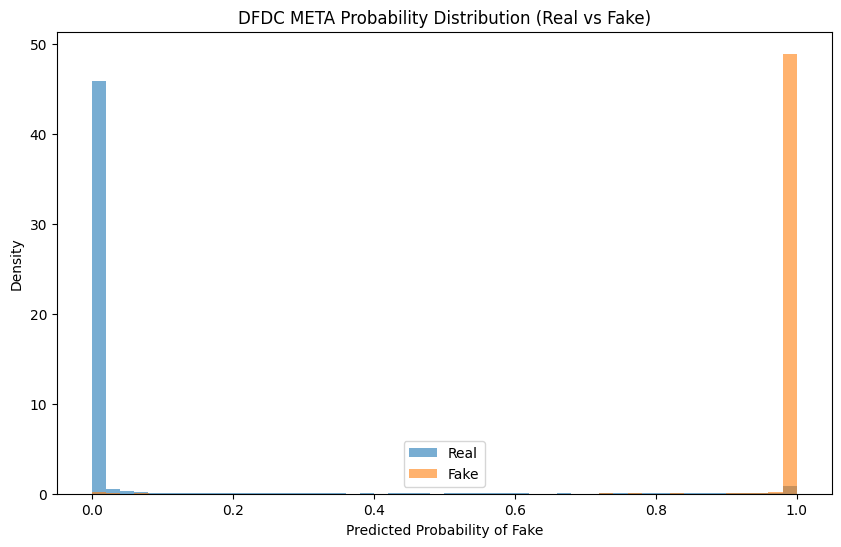

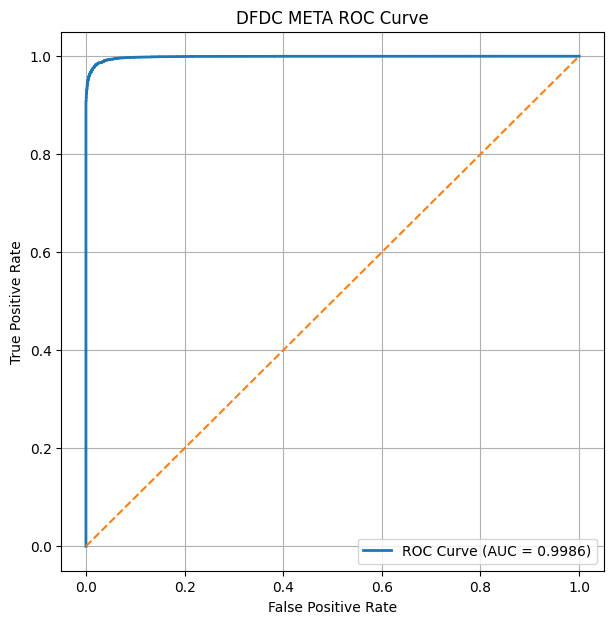

Running t-SNE on META 64-dim features (this can take a while)...


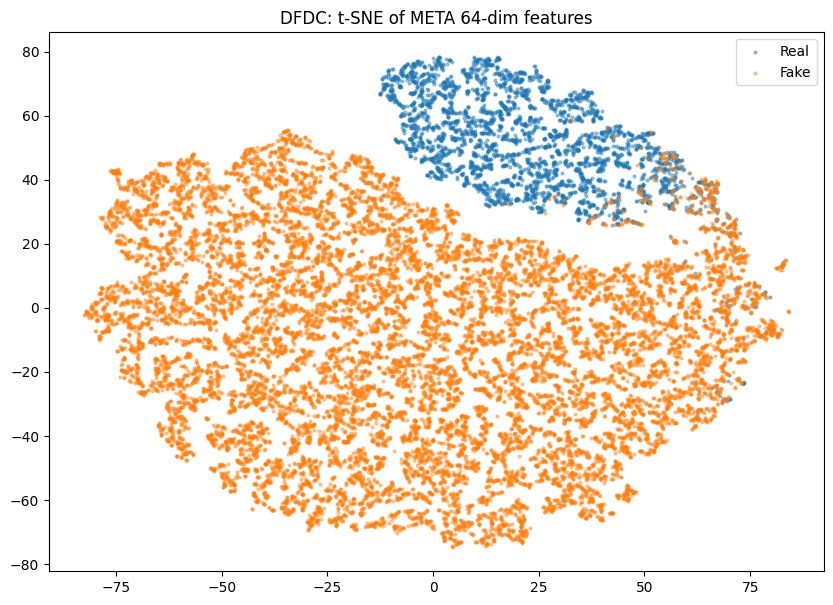

In [9]:
# ================================================
# CELL 5 (DFDC): Visualizations for META output
# ================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE

# so plots show inside notebook
%matplotlib inline

# ------------------------------------------------
# PATHS
# ------------------------------------------------
OUT_DIR = Path("/workspace/oof_stacking_dfdc_xgb64")   # <--- DFDC meta folder
META_CSV = OUT_DIR / "test_meta_full.csv"

if not META_CSV.exists():
    raise FileNotFoundError(f"{META_CSV} not found. Make sure DFDC Cell 1 finished successfully.")

# Load test results
df_test_all = pd.read_csv(META_CSV)

df = df_test_all.copy()
y_true = df["label"].astype(int).to_numpy()
p_meta = df["p_meta"].astype(float).to_numpy()

# ==================================================
# 1) HISTOGRAM of REAL vs FAKE predictions
# ==================================================
plt.figure(figsize=(10,6))
plt.hist(p_meta[y_true == 0], bins=50, alpha=0.6, label="Real", density=True)
plt.hist(p_meta[y_true == 1], bins=50, alpha=0.6, label="Fake", density=True)
plt.title("DFDC META Probability Distribution (Real vs Fake)")
plt.xlabel("Predicted Probability of Fake")
plt.ylabel("Density")
plt.legend()
plt.show()

# ==================================================
# 2) ROC CURVE
# ==================================================
fpr, tpr, _ = roc_curve(y_true, p_meta)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], '--')
plt.title("DFDC META ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

# ==================================================
# 3) t-SNE 2D visualization of META INPUT FEATURES
# ==================================================
# Load the 64-dim feature column names & normalization stats
norm = np.load(OUT_DIR / "meta_norm_full.npz", allow_pickle=True)
feat_cols = norm["feat_cols"].tolist()

# In DFDC test_meta_full.csv, we saved all encoder 64-dim features,
# so we can pull them directly from df using feat_cols:
X = df[feat_cols].to_numpy(dtype=np.float32)

print("Running t-SNE on META 64-dim features (this can take a while)...")
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init="random", random_state=42)
X_2d = tsne.fit_transform(X)

plt.figure(figsize=(10,7))
plt.scatter(
    X_2d[y_true == 0, 0], X_2d[y_true == 0, 1],
    s=4, alpha=0.4, label="Real"
)
plt.scatter(
    X_2d[y_true == 1, 0], X_2d[y_true == 1, 1],
    s=4, alpha=0.4, label="Fake"
)
plt.title("DFDC: t-SNE of META 64-dim features")
plt.legend()
plt.show()
